In [2]:
%matplotlib inline
from astropy.io import fits
from astroquery.mast import Observations
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [10]:
# Global settings
sector = 2
ntargets = 1000
earth_in_view = "((time > 1363.0) & (time < 1366.5)) | ((time > 1379) & (time < 1382))"
ngroups = 4
nreg_per_group = 5
thresh = [1.0, 1.0, 1.0]

In [4]:
# Get the data
obs_id = obs_id="tess*-s00%02d*" % sector
obsTable = Observations.query_criteria(obs_id=obs_id, 
                                       dataproduct_type="timeseries",
                                       obs_collection="TESS",
                                       t_exptime=[119, 121])
obsTable.sort("obs_id")
np.random.seed(41)
inds = np.random.choice(np.arange(len(obsTable), dtype=int), size=ntargets, replace=False)
times = []
fluxes = []
flux_errors = []
for i, ind in tqdm(enumerate(inds), total=ntargets):
    fits_file = "https://mast.stsci.edu/api/v0.1/Download/file/?uri=" + obsTable[ind]["dataURL"]
    with fits.open(fits_file, mode="readonly") as hdulist:
        t = hdulist[1].data['TIME']
        try:
            f = hdulist[1].data['SAP_BKG']
        except (ValueError, KeyError):
            continue
        e = hdulist[1].data['SAP_BKG_ERR']
        q = hdulist[1].data['QUALITY']
        times.append(t[q==0])
        fluxes.append(f[q==0])
        flux_errors.append(e[q==0])

100%|██████████| 1000/1000 [00:29<00:00, 34.39it/s]


In [5]:
# Interpolate to a common time array
ind = np.argmax([len(t) for t in times])
time = np.linspace(times[ind][np.isfinite(times[ind])][0], times[ind][np.isfinite(times[ind])][-1], len(times[ind]))
flux = np.empty((len(times), len(time)))
flux_err = np.empty((len(times), len(time)))
fnorm = np.empty((len(times), len(time)))
rngs = np.empty(len(times))
for i in range(len(fluxes)):
    flux[i] = np.interp(time, times[i], fluxes[i])
    flux_err[i] = np.interp(time, times[i], flux_errors[i])
    fsort = (flux[i])[np.argsort(flux[i])]
    maxf = np.nanmax(fsort[:int(0.95 * len(fsort))])
    minf = np.nanmin(fsort[int(0.05 * len(fsort)):])
    rngs[i] = maxf - minf
    fnorm[i] = (flux[i] - minf) / (maxf - minf)

In [6]:
# Group them by features
group = np.zeros(len(flux), dtype=int)
score = np.zeros(len(flux), dtype=float) * np.nan
med = np.zeros((ngroups, len(time)), dtype=float) * np.nan
sig = np.zeros((ngroups, len(time)), dtype=float) * np.nan

# Loop over groups
for g in tqdm(range(ngroups - 1), total=ngroups - 1):
    # Compute the median absolute deviation of the group
    med[g] = np.nanmedian(fnorm[group==g], axis=0)
    mad = np.nanmedian(np.abs(fnorm[group==g] - med[g]), axis=0)
    sig[g] = 1.4826 * mad

    # Compute reduced chi^2 "score"
    for i in range(len(fluxes)):
        if group[i] == g:
            score[i] = np.nansum((fnorm[i] - med[g]) ** 2 / sig[g] ** 2) / len(time)

    # Remove the outlier light curves from this group
    group[score > thresh[g]] = g + 1

100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


In [7]:
# Sort the light curves by (robust) min-max range
inds = np.argsort(rngs)[::-1]
flux = flux[inds]
flux_err = flux_err[inds]
fnorm = fnorm[inds]
group = group[inds]
score = score[inds]

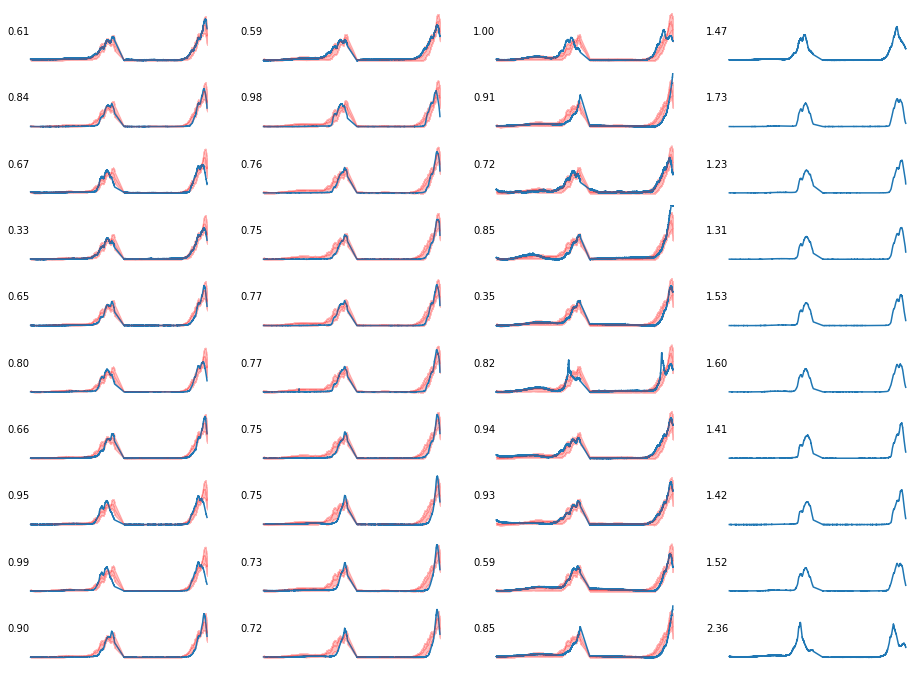

In [8]:
# Plot the first several
nrows = 10
fig, ax = plt.subplots(nrows, ngroups, figsize=(16, 12))
lo = np.nanmin(med[0] - 2 * sig[0])
hi = np.nanmax(med[0] + 2 * sig[0])
for g in range(ngroups):
    for n in range(nrows):
        if n < len(fnorm[group==g]):
            ax[n, g].plot(time, fnorm[group==g][n])
            ax[n, g].plot(time, med[g], "r-", lw=1, alpha=0.25)
            ax[n, g].fill_between(time, med[g] - sig[g], med[g] + sig[g], color="r", alpha=0.25)
            if np.isfinite(score[group==g][n]):
                ax[n, g].annotate("%.2f" % score[group==g][n], xy=(-0.075, 0.5), xycoords="axes fraction")
        ax[n, g].axis('off')
        ax[n, g].set_ylim(lo, hi)

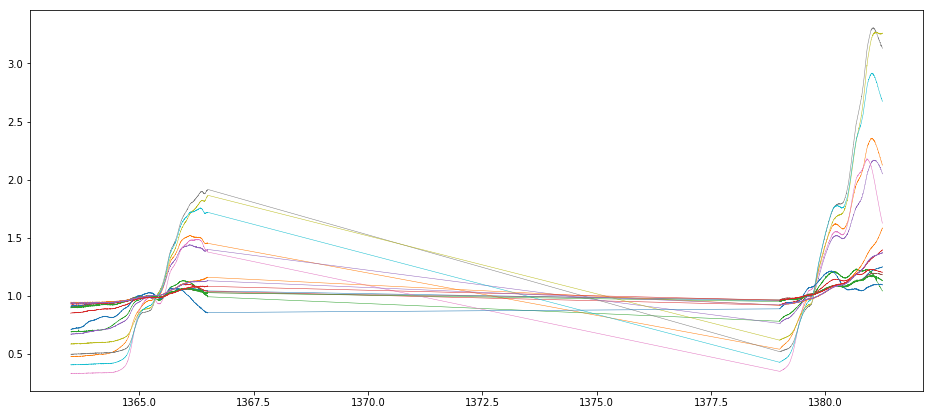

In [16]:
# Mask indices where Earth is not in view (~eyeballed)
earth_in_view = "((time > 1363.5) & (time < 1366.5)) | ((time > 1379) & (time < 1381.25))"
inds = eval(earth_in_view)

# Keep only the first few in each group
times = time[inds]
fluxes = np.empty((nreg_per_group * (ngroups - 1), len(times)))
flux_errs = np.empty((nreg_per_group * (ngroups - 1), len(times)))
i = 0
for g in range(ngroups - 1):
    for n in range(nreg_per_group):
        fluxes[i] = flux[group==g][n][inds]
        norm = np.nanmedian(fluxes[i])
        fluxes[i] /= norm
        flux_errs[i] = flux_err[group==g][n][inds] / norm
        i += 1
        
# Plot our data
fig, ax = plt.subplots(1, figsize=(16, 7))
for f in fluxes:
    plt.plot(times, f, lw=0.5)

In [17]:
# Save the data
np.savez("../data/sector%02d-data.npz" % sector, time=times, flux=fluxes, flux_err=flux_errs)

In [19]:
import earthshine
import starry_beta
map = starry_beta.Map(15)
map.load_image("earth")
yearth = np.array(map.y)

import starry
map = starry.Map(15, reflected=True, nt=1)
map[:, :, 0] = yearth
flux_num = earthshine.animate(map, times[::10], res=50)

100%|██████████| 351/351 [00:17<00:00, 19.25it/s]
